**Somebody come up with a research question I'm too lazy.**  
~ Alex

In [9]:
# Load things that we need
library(tidyverse)
library(repr)
library(caret)

Loading required package: lattice

Attaching package: ‘caret’

The following object is masked from ‘package:purrr’:

    lift



In [49]:
# Get the data
# Brute force column names because I have no better solution
phishing_columns <- c("having_IP_address",
                      "URL_Length",
                     "Shortening_Service",
                     "having_At_Symbol",
                     "double_slash_redirecting",
                     "Prefix_Suffix",
                     "having_Sub_Domain",
                     "SSLfinal_State",
                     "Domain_registration_length",
                     "Favicon",
                     "port",
                     "HTTPS_token",
                     "Request_URL",
                     "URL_of_Anchor",
                     "Links_in_tags",
                     "SFH",
                     "Submitting_to_email",
                     "Abnormal_URL",
                     "Redirect",
                     "on_mouseover",
                     "RightClick",
                     "popUpWindow",
                     "Iframe",
                     "age_of_domain",
                     "DNSRecord",
                     "web_traffic",
                     "Page_Rank",
                     "Google_Index",
                     "Links_pointing_to_page",
                     "Statistical_report",
                     "Result")
# Assign and display, change result type to factor
phishing <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00327/Training%20Dataset.arff" %>%
                read_csv(skip = 36, col_names = phishing_columns) %>%
                mutate(Result = as.factor(Result))
head(phishing)

Parsed with column specification:
cols(
  .default = col_double()
)
See spec(...) for full column specifications.


having_IP_address,URL_Length,Shortening_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registration_length,Favicon,⋯,popUpWindow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Result
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
-1,1,1,1,-1,-1,-1,-1,-1,1,⋯,1,1,-1,-1,-1,-1,1,1,-1,-1
1,1,1,1,1,-1,0,1,-1,1,⋯,1,1,-1,-1,0,-1,1,1,1,-1
1,0,1,1,1,-1,-1,-1,-1,1,⋯,1,1,1,-1,1,-1,1,0,-1,-1
1,0,1,1,1,-1,-1,-1,1,1,⋯,1,1,-1,-1,1,-1,1,-1,1,-1
1,0,-1,1,1,-1,1,1,-1,1,⋯,-1,1,-1,-1,0,-1,1,1,1,1
-1,0,-1,1,-1,-1,1,1,-1,1,⋯,1,1,1,1,1,-1,1,-1,-1,1


In [6]:
# Turn result into factor
phishing_resfactored <- mutate(phishing, Result = as.factor(Result))

Information comes from https://archive.ics.uci.edu/ml/machine-learning-databases/00327/Phishing%20Websites%20Features.docx
Values in the file are interpreted as follows:  

- having_IP_address: 1 if URL contains IP address rather than domain name, 0 otherwise
- URL_Length: 1 if URL is more than 75 characters in length, 0 if URL is between 54 and 75 characters in length, -1 otherwise
- Shortening_Service: 1 if a URL shortening service, such as TinyURL is used, -1 otherwise
- having_At_Symbol: 1 if URL has an @ symbol, -1 otherwise
- double_slash_redirecting: 1 if "//" occurs after position 7 in a URL, -1 otherwise
- Prefix_Suffix: 1 if URL contains "-", -1 otherwise
- having_Sub_Domain: -1 if portion of URL *BESIDES THE COUNTRY-CODE TOP-LEVEL DOMAINS* contains 1 "." character, 0 if it contains 2, 1 otherwise
- SSLfinal_state: -1 if https is used and certificate is trusted (trusted issuer, and at least one year old), 0 if https is used and certificate not trusted, 1 otherwise
- Domain_registration_length: 1 if domain expires in a year, -1 otherwise
- Favicon: 1 if Favicon loaded from external domain, -1 otherwise
- port: SEE DOC, INTERPRETATION UNCLEAR
- HTTPS_token: 1 if HTTP token in domain part of URL, -1 otherwise
- Request_URL: 1 if at least 61% of objects are loaded externally, 0 if between 61% and 22% objects are loaded externally, -1 otherwise
- URL_of_Anchor: 1 if URL anchor is greater than 67% of the total URL, 0 if URL anchor is between 67% and 31% of the total URL, -1 otherwise
- Links_in_tags: 1 if more than 81% of metadata tags contain links, 0 if between 81% and 17% of tags contain links, -1 otherwise
- SFH: 1 if SFH is "about: blank", 0 if SFH refers to different domain, -1 otherwise
- Submitting_to_email: 1 if "mail()" or "mailto" is used, -1 otherwise
- Abnormal_URL: 1 if URL does not contain host name, -1 otherwise
- Redirect: 1 if webpage redirects is greater than 3, 0 if between 2 or 3 redirects used, (-1 not present here)
- on_mouseover: 1 if mousing over a link on the site changes the status bar, -1 otherwise
- RightClick: 1 if right click disabled, -1 otherwise
- PopUpWindow: 1 if popup windows contain text fields, -1 otherwise
- Iframe: 1 if iframe used, -1 otherwise
- age_of_domain: 1 if domain is less than 6 months olds, -1 otherwise
- DNSRecord: 1 if no DNS record, -1 otherwise
- web_traffic: 1 if website is not found in Alexa database, 0 if ranked below is rated below 100000th in Alexa database, -1 otherwise
- Page_Rank: 1 if page rank is less than 0.2, -1 otherwise
- Google_Index: 1 if page is not indexed by Google, -1 otherwise
- Links_pointing_to_page: 1 if page has no external links leading to it, 0 if page has 1 or 2 external links leading to it, -1 otherwise
- Statistical_report: 1 if host belongs to top phishing IPs/domains, -1 otherwise

Result: -1 is legitimate, 1 is phishing website.

At this point we need a research question before we can do anything else so...

In [59]:
set.seed(1)
# Paring down dataset to what we will be working with:
working_data <- sample_n(phishing, size = 1000)
working_columns <- c("URL_Length", "having_At_Symbol", "Prefix_Suffix", "Favicon", "port", "SFH", "Abnormal_URL", "Redirect", "on_mouseover", "popUpWindow", "Iframe", "Statistical_report", "Result")

# Splitting data into training and testing sets:
training_rows <- working_data %>%
                    select(Result) %>%
                    unlist() %>%
                    createDataPartition(p=0.75, list=FALSE)
training_data <- working_data %>%
                    slice(training_rows) %>%
                    select(working_columns)
testing_data <- working_data %>%
                    slice(-training_rows) %>%
                    select(working_columns)

# Prepping for training:
X_train <- training_data %>%
                select(-Result) %>%
                data.frame()
Y_train <- training_data %>%
                select(Result) %>%
                unlist()
X_test <- testing_data %>%
                select(-Result) %>%
                data.frame()
Y_test <- testing_data %>%
                select(Result) %>%
                unlist()

In [70]:
# Performing five-fold cross-validation to pick k
set.seed(1)
k_test = data.frame(k=seq(from = 1, to = 150, by = 1))
train_control <- trainControl(method="cv", number=5)
choose_k <- train(x=X_train, y=Y_train, method="knn", tuneGrid = k_test, trControl = train_control)
choose_k

k-Nearest Neighbors 

751 samples
 12 predictor
  2 classes: '-1', '1' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 600, 601, 601, 601, 601 
Resampling results across tuning parameters:

  k    Accuracy   Kappa    
    1  0.6724415  0.3565300
    2  0.6657925  0.3469450
    3  0.6577925  0.3313805
    4  0.6564680  0.3282940
    5  0.6631082  0.3422796
    6  0.6671258  0.3476476
    7  0.6657748  0.3448691
    8  0.6697925  0.3522187
    9  0.6724503  0.3568861
   10  0.6724415  0.3567815
   11  0.6844415  0.3788736
   12  0.6844503  0.3800196
   13  0.6857837  0.3811848
   14  0.6751170  0.3594933
   15  0.6777748  0.3662519
   16  0.6817572  0.3733520
   17  0.6790993  0.3680646
   18  0.6804238  0.3708911
   19  0.6790905  0.3692603
   20  0.6830728  0.3772802
   21  0.6817395  0.3754715
   22  0.6830728  0.3790773
   23  0.6738190  0.3632949
   24  0.6738102  0.3640073
   25  0.6724945  0.3613309
   26  0.6738190  0.3641101
   27  0.6631700  0

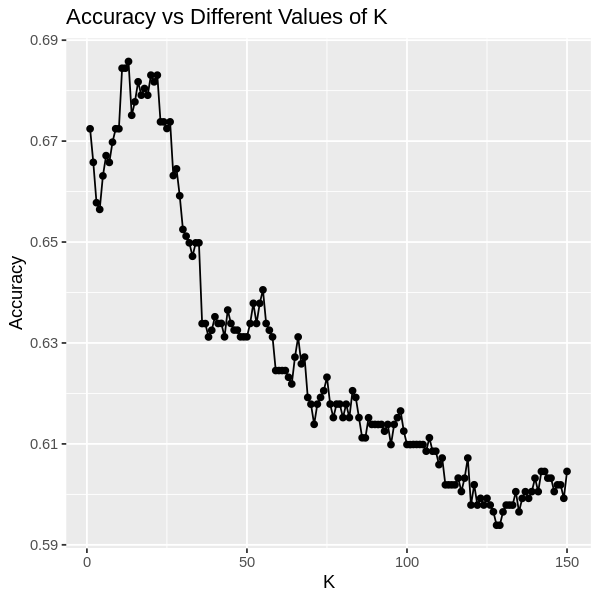

In [72]:
# Visualizing the different accuracies vs their k values to be confident in the choice of k. 
options(repr.plot.width=5, repr.plot.height=5)
accuracies  <- choose_k$results %>%
                    select(k, Accuracy)
accuracies_plot <- ggplot(accuracies, aes(x=k, y=Accuracy)) +
                        geom_point() +
                        geom_line() +
                        labs(x="K", y="Accuracy", title="Accuracy vs Different Values of K")
accuracies_plot

In [82]:
# Training knn_model
knn_model <- train(x=X_train, y=Y_train, method="knn", tuneGrid=data.frame(k=13))
predictions <- predict(knn_model, X_test)
model_quality <- confusionMatrix(data = predictions, reference = Y_test)
model_quality

Confusion Matrix and Statistics

          Reference
Prediction -1  1
        -1 78 65
        1  33 73
                                          
               Accuracy : 0.6064          
                 95% CI : (0.5428, 0.6675)
    No Information Rate : 0.5542          
    P-Value [Acc > NIR] : 0.055005        
                                          
                  Kappa : 0.2253          
                                          
 Mcnemar's Test P-Value : 0.001739        
                                          
            Sensitivity : 0.7027          
            Specificity : 0.5290          
         Pos Pred Value : 0.5455          
         Neg Pred Value : 0.6887          
             Prevalence : 0.4458          
         Detection Rate : 0.3133          
   Detection Prevalence : 0.5743          
      Balanced Accuracy : 0.6158          
                                          
       'Positive' Class : -1              
                                    